# Expression Token Length Analysis (Random Sampling)

This notebook analyzes the token length distribution of expressions in the superfib_r1.csv dataset.
Instead of processing the entire large file, we randomly sample 100,000 rows for efficient analysis.

In [18]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from collections import Counter
from tqdm import tqdm
import random

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

In [19]:
# File path configuration
data_path = Path('/home/takeruito/work/PrfSR/data/training/superfib_r1.csv')
SAMPLE_SIZE = 100000  # Number of random samples to extract

# Check if file exists
if not data_path.exists():
    raise FileNotFoundError(f'Dataset not found at {data_path}')

print(f'Analyzing dataset: {data_path}')
print(f'File size: {data_path.stat().st_size / (1024**2):.2f} MB')
print(f'Target sample size: {SAMPLE_SIZE:,}')

Analyzing dataset: /home/takeruito/work/PrfSR/data/training/superfib_r1.csv
File size: 3060.49 MB
Target sample size: 100,000


In [20]:
def count_total_rows(file_path):
    """
    Efficiently count total number of rows in the CSV file.
    """
    print('Counting total rows in the dataset...')
    with open(file_path, 'r') as f:
        # Skip header and count data rows
        next(f)  # Skip header
        total_rows = sum(1 for _ in f)
    return total_rows


def get_random_sample_indices(total_rows, sample_size):
    """
    Generate random row indices for sampling.
    """
    if sample_size >= total_rows:
        print(f'Sample size ({sample_size:,}) >= total rows ({total_rows:,}). Using all data.')
        return list(range(total_rows))
    
    print(f'Generating {sample_size:,} random indices from {total_rows:,} total rows...')
    return sorted(random.sample(range(total_rows), sample_size))

In [21]:
def tokenize_expression(expr):
    """
    Simple tokenization function for mathematical expressions.
    Splits on operators, parentheses, and whitespace.
    """
    if pd.isna(expr):
        return []
    
    # Split on operators and parentheses while keeping them
    tokens = re.findall(r'\w+|[+\-*/()^]', str(expr))
    return [token for token in tokens if token.strip()]


def get_token_length(expr):
    """Get the number of tokens in an expression."""
    return len(tokenize_expression(expr))

In [22]:
def read_random_sample(file_path, sample_indices):
    """
    Read only the randomly selected rows from the CSV file.
    """
    print(f'Reading {len(sample_indices):,} random samples...')
    
    # Read header first
    header = pd.read_csv(file_path, nrows=0).columns.tolist()
    
    # Check if 'expr' column exists
    if 'expr' not in header:
        print(f'Available columns: {header}')
        raise KeyError("Column 'expr' not found in the dataset")
    
    sampled_data = []
    current_row = 0
    sample_idx = 0
    
    with open(file_path, 'r') as f:
        # Skip header
        next(f)
        
        for line in tqdm(f, desc='Reading samples'):
            if sample_idx < len(sample_indices) and current_row == sample_indices[sample_idx]:
                sampled_data.append(line.strip())
                sample_idx += 1
            current_row += 1
            
            # Early termination if we've collected all samples
            if sample_idx >= len(sample_indices):
                break
    
    # Convert to DataFrame
    from io import StringIO
    csv_string = '\n'.join([','.join(header)] + sampled_data)
    df = pd.read_csv(StringIO(csv_string))
    
    print(f'Successfully loaded {len(df):,} samples')
    return df

In [23]:
# Step 1: Count total rows
total_rows = count_total_rows(data_path)
print(f'Total data rows in dataset: {total_rows:,}')

# Step 2: Generate random sample indices
sample_indices = get_random_sample_indices(total_rows, SAMPLE_SIZE)
print(f'Selected {len(sample_indices):,} random row indices')

# Step 3: Read random sample
sample_df = read_random_sample(data_path, sample_indices)

Counting total rows in the dataset...


Total data rows in dataset: 6,191,000
Generating 100,000 random indices from 6,191,000 total rows...
Selected 100,000 random row indices
Reading 100,000 random samples...


Reading samples: 6190998it [00:05, 1188383.15it/s]



Successfully loaded 100,000 samples


In [24]:
# Analyze token lengths for the random sample
print('Calculating token lengths for sampled expressions...')
sample_df['token_length'] = sample_df['expr'].apply(get_token_length)
token_lengths = sample_df['token_length'].values

print(f'\nAnalysis complete!')
print(f'Sample size: {len(token_lengths):,} expressions')
print(f'Sampling ratio: {len(token_lengths)/total_rows*100:.2f}%')
print(f'Token length statistics:')
print(f'  Mean: {np.mean(token_lengths):.2f}')
print(f'  Median: {np.median(token_lengths):.2f}')
print(f'  Min: {np.min(token_lengths)}')
print(f'  Max: {np.max(token_lengths)}')
print(f'  Std: {np.std(token_lengths):.2f}')

Calculating token lengths for sampled expressions...



Analysis complete!
Sample size: 100,000 expressions
Sampling ratio: 1.62%
Token length statistics:
  Mean: 292.39
  Median: 289.00
  Min: 69
  Max: 636
  Std: 77.06


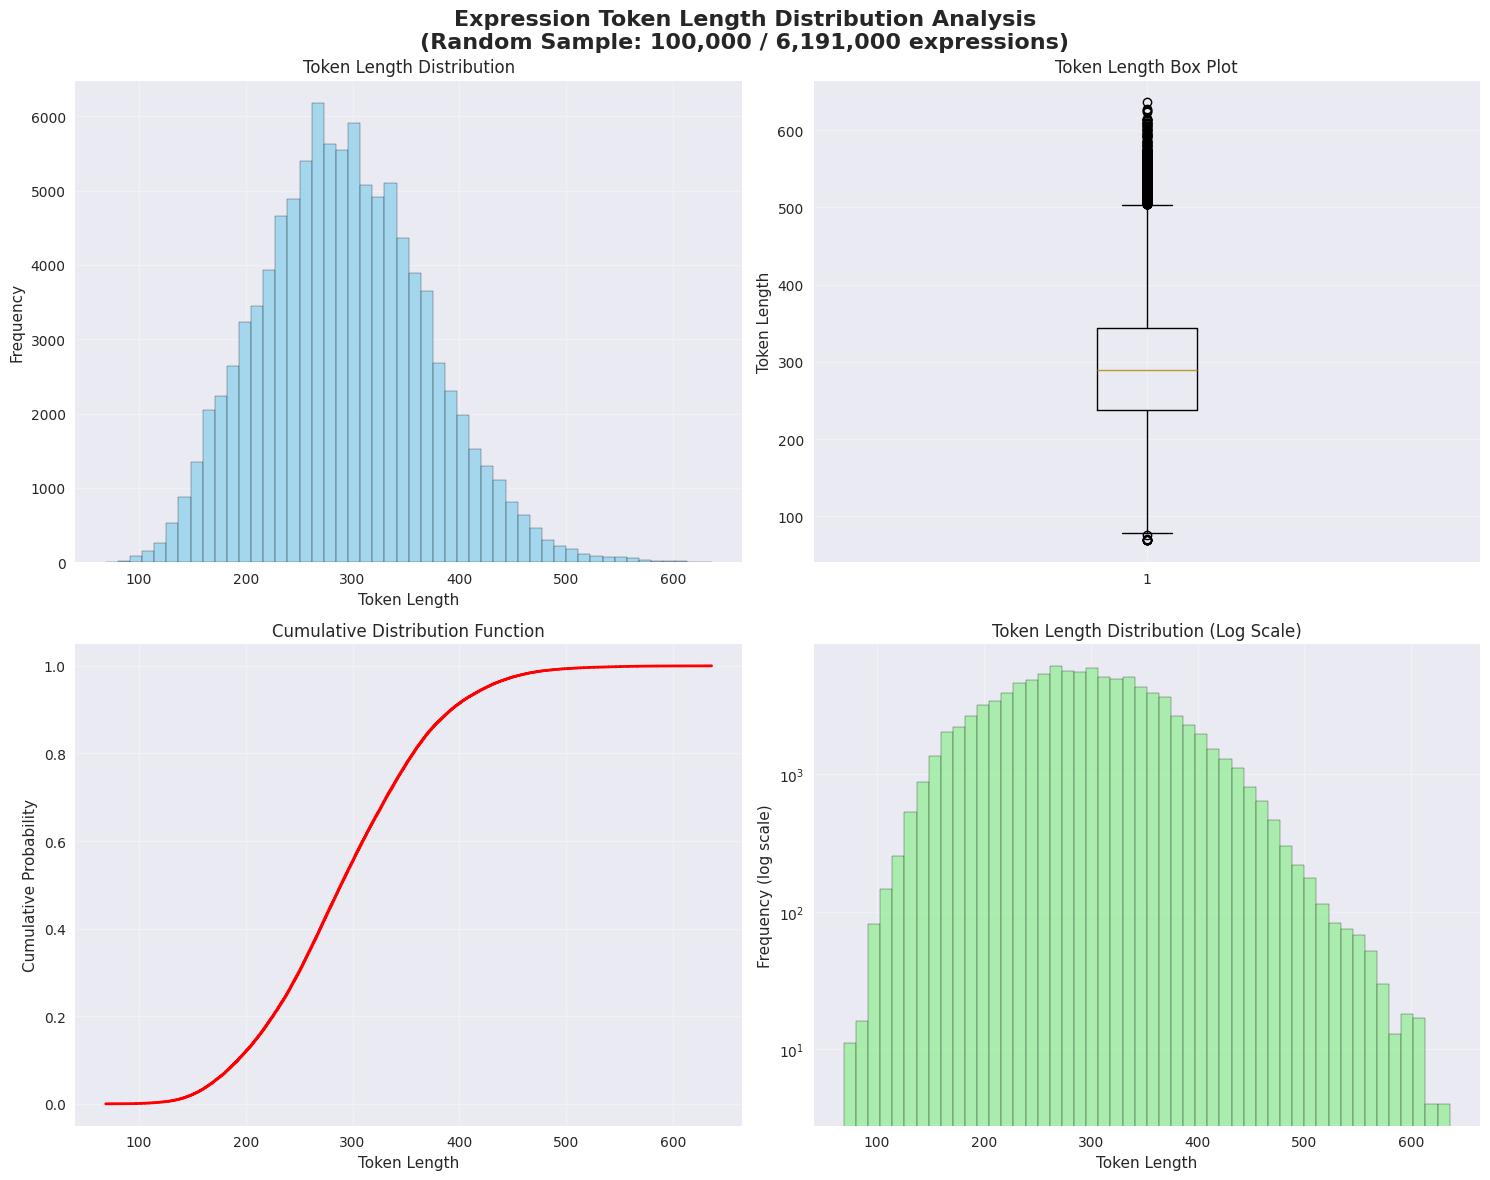

In [25]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f'Expression Token Length Distribution Analysis\n(Random Sample: {len(token_lengths):,} / {total_rows:,} expressions)', fontsize=16, fontweight='bold')

# 1. Main histogram
axes[0, 0].hist(token_lengths, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
axes[0, 0].set_xlabel('Token Length')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Token Length Distribution')
axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot
axes[0, 1].boxplot(token_lengths)
axes[0, 1].set_ylabel('Token Length')
axes[0, 1].set_title('Token Length Box Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Cumulative distribution
sorted_lengths = np.sort(token_lengths)
cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
axes[1, 0].plot(sorted_lengths, cumulative, linewidth=2, color='red')
axes[1, 0].set_xlabel('Token Length')
axes[1, 0].set_ylabel('Cumulative Probability')
axes[1, 0].set_title('Cumulative Distribution Function')
axes[1, 0].grid(True, alpha=0.3)

# 4. Log-scale histogram for better visibility of tail
axes[1, 1].hist(token_lengths, bins=50, alpha=0.7, edgecolor='black', color='lightgreen')
axes[1, 1].set_xlabel('Token Length')
axes[1, 1].set_ylabel('Frequency (log scale)')
axes[1, 1].set_yscale('log')
axes[1, 1].set_title('Token Length Distribution (Log Scale)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [26]:
# Detailed statistics and percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
percentile_values = np.percentile(token_lengths, percentiles)

print('\nDetailed Token Length Statistics:')
print('=' * 40)
for p, v in zip(percentiles, percentile_values):
    print(f'{p:2d}th percentile: {v:6.1f}')

# Show distribution of token lengths
print('\nToken Length Frequency (Top 20):')
print('=' * 40)
length_counts = Counter(token_lengths)
for length, count in length_counts.most_common(20):
    percentage = (count / len(token_lengths)) * 100
    print(f'Length {length:2d}: {count:6,} expressions ({percentage:5.2f}%)')


Detailed Token Length Statistics:
 1th percentile:  137.0
 5th percentile:  170.0
10th percentile:  193.0
25th percentile:  238.0
50th percentile:  289.0
75th percentile:  344.0
90th percentile:  392.0
95th percentile:  425.0
99th percentile:  484.0

Token Length Frequency (Top 20):
Length 293:    550 expressions ( 0.55%)
Length 287:    549 expressions ( 0.55%)
Length 272:    543 expressions ( 0.54%)
Length 268:    539 expressions ( 0.54%)
Length 269:    538 expressions ( 0.54%)
Length 296:    538 expressions ( 0.54%)
Length 278:    536 expressions ( 0.54%)
Length 276:    526 expressions ( 0.53%)
Length 281:    526 expressions ( 0.53%)
Length 302:    526 expressions ( 0.53%)
Length 254:    522 expressions ( 0.52%)
Length 262:    522 expressions ( 0.52%)
Length 283:    520 expressions ( 0.52%)
Length 274:    519 expressions ( 0.52%)
Length 275:    518 expressions ( 0.52%)
Length 253:    515 expressions ( 0.52%)
Length 286:    513 expressions ( 0.51%)
Length 273:    512 expressions ( 0.

In [27]:
# Sample expression analysis from our random sample
print('\nSample Expression Analysis:')
print('=' * 40)

# Show examples of different token lengths from our sample
print('Examples of expressions by token length:')
for length in sorted(sample_df['token_length'].unique())[:10]:  # Show first 10 lengths
    examples = sample_df[sample_df['token_length'] == length]['expr'].head(2)
    print(f'\nLength {length}:')
    for expr in examples:
        tokens = tokenize_expression(expr)
        print(f'  Expression: {expr}')
        print(f'  Tokens: {tokens}')


Sample Expression Analysis:
Examples of expressions by token length:

Length 69:
  Expression: R(C(S(), S()), R(P(2, 1), P(4, 3), C(S(), P(4, 2)), C(S(), S()), S()), C(C(S(), S()), C(S(), Z())))
  Tokens: ['R', '(', 'C', '(', 'S', '(', ')', 'S', '(', ')', ')', 'R', '(', 'P', '(', '2', '1', ')', 'P', '(', '4', '3', ')', 'C', '(', 'S', '(', ')', 'P', '(', '4', '2', ')', ')', 'C', '(', 'S', '(', ')', 'S', '(', ')', ')', 'S', '(', ')', ')', 'C', '(', 'C', '(', 'S', '(', ')', 'S', '(', ')', ')', 'C', '(', 'S', '(', ')', 'Z', '(', ')', ')', ')', ')']

Length 70:
  Expression: C(R(C(S(), P(3, 1)), C(S(), P(4, 3)), P(4, 4), P(4, 2), C(S(), Z()), C(S(), Z()), Z()), C(S(), P(4, 2)))
  Tokens: ['C', '(', 'R', '(', 'C', '(', 'S', '(', ')', 'P', '(', '3', '1', ')', ')', 'C', '(', 'S', '(', ')', 'P', '(', '4', '3', ')', ')', 'P', '(', '4', '4', ')', 'P', '(', '4', '2', ')', 'C', '(', 'S', '(', ')', 'Z', '(', ')', ')', 'C', '(', 'S', '(', ')', 'Z', '(', ')', ')', 'Z', '(', ')', ')', 'C', '(', 'S', '

In [28]:
# Sampling quality assessment
print('\nSampling Quality Assessment:')
print('=' * 40)
print(f'Total dataset size: {total_rows:,} rows')
print(f'Sample size: {len(token_lengths):,} rows')
print(f'Sampling ratio: {len(token_lengths)/total_rows*100:.3f}%')
print(f'Statistical power: High (n > 30,000 recommended for population inference)')

# Calculate confidence intervals for mean
from scipy import stats
confidence_level = 0.95
degrees_freedom = len(token_lengths) - 1
sample_mean = np.mean(token_lengths)
sample_std = np.std(token_lengths, ddof=1)
standard_error = sample_std / np.sqrt(len(token_lengths))
confidence_interval = stats.t.interval(confidence_level, degrees_freedom, sample_mean, standard_error)

print(f'\n95% Confidence Interval for Population Mean:')
print(f'Sample mean: {sample_mean:.3f}')
print(f'CI: [{confidence_interval[0]:.3f}, {confidence_interval[1]:.3f}]')

# Save results for future use
results_summary = {
    'total_dataset_size': total_rows,
    'sample_size': len(token_lengths),
    'sampling_ratio': len(token_lengths)/total_rows,
    'mean_length': float(np.mean(token_lengths)),
    'median_length': float(np.median(token_lengths)),
    'min_length': int(np.min(token_lengths)),
    'max_length': int(np.max(token_lengths)),
    'std_length': float(np.std(token_lengths)),
    'confidence_interval_95': [float(confidence_interval[0]), float(confidence_interval[1])],
    'percentiles': {f'p{p}': float(v) for p, v in zip(percentiles, percentile_values)}
}

print('\nAnalysis completed successfully!')
print('Token length distribution has been analyzed using random sampling.')
print(f'Results are representative of the full dataset with high confidence.')


Sampling Quality Assessment:
Total dataset size: 6,191,000 rows
Sample size: 100,000 rows
Sampling ratio: 1.615%
Statistical power: High (n > 30,000 recommended for population inference)



95% Confidence Interval for Population Mean:
Sample mean: 292.391
CI: [291.913, 292.868]

Analysis completed successfully!
Token length distribution has been analyzed using random sampling.
Results are representative of the full dataset with high confidence.
